In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import os
from io import BytesIO
import base64
from PIL import Image

# 환경변수(.env)에서 OpenAI API 키 로드
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

In [2]:
# 이미지를 base64로 인코딩하는 함수
def encode_image(image):
    buffered = BytesIO()
    w, h = image.size
    if w > 512 or h > 512:
        scale = 512 / max(w, h)
    else:
        scale = 1.0
    resize_im = image.resize((int(w * scale), int(h * scale)))
    resize_im.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

In [3]:
# GPT에게 이미지와 질문을 보내고 객체 탐지 결과 받기
def obj_detection(prompt, image):
    client = OpenAI(api_key=api_key)
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "Given the image, answer the following question."
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{encode_image(image)}"
                        }
                    }
                ]
            }
        ]
    )
    return response.choices[0].message.content

##GPT-4o : 시각-언어 모델
- OpenAI의 vision model은 YOLO나 Faster R-CNN처럼 픽셀 단위 객체 감지를 하는 모델은 아님

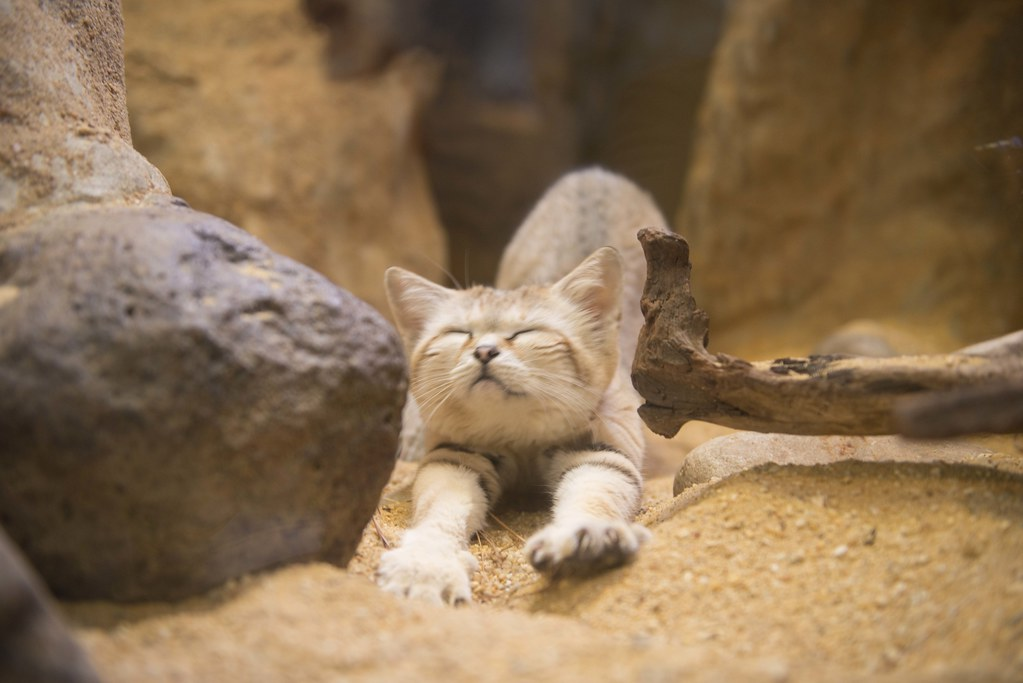

이미지 중앙에 고양이가 있습니다. 강아지는 보이지 않습니다.


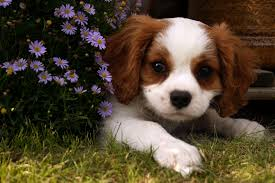

이미지 중앙에 강아지가 있습니다. 고양이는 보이지 않습니다.


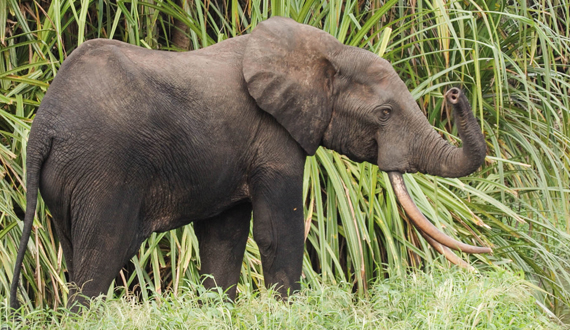

이미지에는 강아지나 고양이가 없습니다. 이미지는 코끼리를 보여주고 있습니다.


In [4]:
# prompt1 = f"""
# Question: Locate the position of all objects in the image. Objects: [Dog, Cat]
# """
# prompt2 = f"""
# Please analyze this image. Are there any cats or dogs in the image? \
#                         If possible, could you also describe roughly where each object appears, such as 'left side', 'center', or 'bottom right'? \
#                         Also, mention the confidence score between 0 and 1.
# """                        

prompt1 = f"""
질문: 이미지에서 다음 객체들의 위치를 찾아주세요. 객체 목록: [강아지, 고양이]
"""

prompt2 = f"""
이 이미지를 분석해주세요. 이미지에 고양이나 강아지가 있나요? \
가능하다면 각 객체가 대략 어디에 위치해 있는지도 알려주세요. 예: '왼쪽', '중앙', '오른쪽 아래' 등. \
또한, 각 객체에 대한 신뢰도 점수(0에서 1 사이의 값)도 함께 알려주세요. 객체가 없으면 0이라고 말해줘요.
"""
# 'imgs_objDetection' 폴더에서 .jpg 파일만 리스트로 가져오기
files = [f for f in os.listdir('imgs_objDetection') if f.endswith('jpeg')]

# 파일 이름 순으로 정렬하여 하나씩 처리
for f in sorted(files):
    img = Image.open(os.path.join('imgs_objDetection', f))  # 이미지 열기
    response = obj_detection(prompt1, img)  # GPT로부터 분류 결과 받기
    display(img)  # 이미지 출력
    print(response)  # 결과 출력